In [1]:
import pandas as pd 
import numpy as np
import time
import re 
import itertools
import jieba.posseg as psg
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from gensim import corpora, models
from matplotlib.font_manager import FontProperties
plt.rcParams['font.sans-serif'] = ['SimHei'] # 解决中文乱码问题
plt.rcParams['axes.unicode_minus'] = False # 解决负号无法正常显示的问题
%config InlineBackend.figure_format = 'svg' # 将图标设置成矢量图格式显示，会更清晰
plt.style.use('Solarize_Light2') # 设置绘图样式

In [2]:
data = pd.read_csv('武汉.csv',encoding='utf8')
data.head()

,标题,时间,阅读量
0,就等你来！荆楚网招募视频拍客,2019,4237297
1,涉“网络内容从业人员违法违规行为”网上有害信息举报专帖,2021,1060364
2,【发帖必读】大武汉版版规,2015,609902
3,这是一枝黄花吗？,2021,2603
4,联合国气候变化框架公约缔约方大会第二十六次会议（COP26）将于11月在格拉斯哥举行,2021,27215


[(2011, 395), (2012, 3681), (2013, 6294), (2014, 3955), (2015, 6242), (2016, 2798), (2017, 2209), (2018, 4228), (2019, 3734), (2020, 2375), (2021, 1482)]


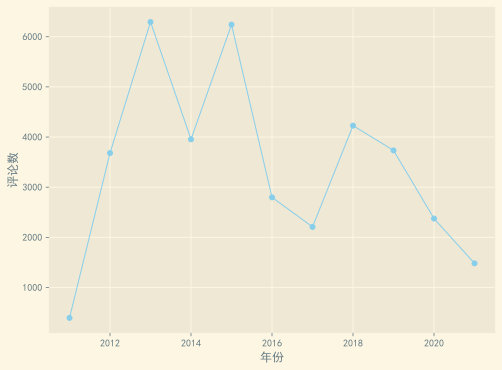

In [3]:
time_year = data['时间'].value_counts()
year = list(time_year.index)
count = (time_year.values)
time_year = list(zip(year,count))
time_year = sorted(time_year,key=lambda x: x[0])
print(time_year)

# 绘制折线图
x = [time[0] for time in time_year]
y = [time[1] for time in time_year]
fig = plt.figure(figsize=(8,6))
plt.plot(x,y,color='skyblue',linewidth=1,marker='o',markersize=5)
plt.xlabel('年份')
plt.ylabel('评论数')
plt.show()

In [4]:
display(data.shape)
comments = data[['标题']].drop_duplicates()
display(comments.shape)

(37393, 3)

(36356, 1)

In [5]:
comments = comments.dropna()
comments.shape

(36356, 1)

In [6]:
str_re = re.compile('[a-zA-Z0-9]|武汉|新人|报到')
comments['标题'] = comments['标题'].apply(lambda x: str_re.sub('',x))

In [7]:
# 把每条评论分词，并标注每个词的词性
worker = lambda s: [(x.word,x.flag) for x in psg.cut(s)] # 自定义简单分词函数
seg_word = comments['标题'].apply(worker)
seg_word.head()

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\86158\AppData\Local\Temp\jieba.cache
Loading model cost 1.055 seconds.
Prefix dict has been built successfully.


0    [(就, d), (等, u), (你, r), (来, v), (！, x), (荆楚网,...
1    [(涉, v), (“, x), (网络, n), (内容, n), (从业人员, l), ...
2    [(【, x), (发帖, n), (必读, v), (】, x), (大, a), (版,...
3          [(这, r), (是, v), (一枝黄花, i), (吗, y), (？, x)]
4    [(联合国, nt), (气候变化, n), (框架, n), (公约, n), (缔约方,...
Name: 标题, dtype: object

In [8]:
# 每一条评论中的词的个数
n_word = seg_word.apply(lambda x: len(x))

# 把每条评论的 id 弄成列表，例如第一条评论 id 为 1，有 3 个分词，第二条评论 id 为 2，
# 两个分词，那结果：[[1,1,1],[2,2]] 以此类推
n_content = [[x+1]*y for x,y in zip(list(seg_word.index),list(n_word))]
index_content = sum(n_content,[]) # 将嵌套列表展开，作为词所在评论 id

In [ ]:
seg_word = sum(seg_word,[]) # 列表。形式：[(词，词性)....]
word = [x[0] for x in seg_word] # 词
nature = [x[1] for x in seg_word] # 词性

In [ ]:
# 转为数据框，第一列为词所在评论id，第二列词语，第三列词性
result = pd.DataFrame({'index_content':index_content,
                       'word':word,
                       'nature':nature,
                       })
result.head()

In [ ]:
# 词性为 x，代表标点符号，删除
result = result[result['nature'] != 'x']

In [12]:
# 删除停用词
stop_path = open(r'stoplist.txt','r',encoding='utf8')
stop = stop_path.readlines()
stop = [x.replace('\n','') for x in stop]
word = list(set(word) - set(stop))
result = result[result['word'].isin(word)]

In [13]:
# 构造各词在对应评论的位置列
n_word = list(result.groupby('index_content')['index_content'].count())
index_word = [list(np.arange(0, y)) for y in n_word]
index_word = sum(index_word, [])  # 表示词语在该评论的位置

# 合并评论id，评论中词的id，词，词性
result['index_word'] = index_word
result.head()

,index_content,word,nature,index_word
5,1,荆楚网,nr,0
6,1,招募,v,1
7,1,视频,n,2
8,1,拍,v,3
9,1,客,n,4


In [14]:
ind = result[[('n' in x) or ('adj' in x) for x in result['nature']]]['index_content'].unique()
result = result[[x in ind for x in result['index_content']]]

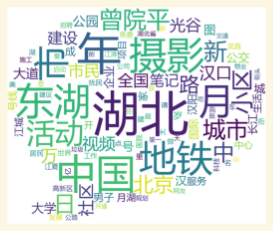

In [22]:
frequencies = result.groupby(by = ['word'])['word'].count()
frequencies = frequencies.sort_values(ascending = False)
backgroud_Image=plt.imread(r'pl.jpg')
wordcloud = WordCloud(font_path="msyh.ttc",
                      max_words=100,
                      background_color='white',
                      mask=backgroud_Image)
my_wordcloud = wordcloud.fit_words(frequencies)
plt.imshow(my_wordcloud)
plt.axis('off')
plt.savefig(r'综合情感词云.png')
plt.show()

# 将结果写出
result.to_csv(r"word.csv",index=False,encoding='utf-8')

In [23]:
word = result

# 读入正面、负面情感评价词
pos_comment = pd.read_csv(r'正面评价词语（中文）.txt', header=None,sep="\n",
                          encoding = 'utf-8', engine='python')
neg_comment = pd.read_csv(r'负面评价词语（中文）.txt', header=None,sep="\n",
                          encoding = 'utf-8', engine='python')
pos_emotion = pd.read_csv(r'正面情感词语（中文）.txt', header=None,sep="\n",
                          encoding = 'utf-8', engine='python')
neg_emotion = pd.read_csv(r'负面情感词语（中文）.txt', header=None,sep="\n",
                          encoding = 'utf-8', engine='python')

In [24]:
# 合并情感词与评价词
positive = set(pos_comment.iloc[:,0])|set(pos_emotion.iloc[:,0])
negative = set(neg_comment.iloc[:,0])|set(neg_emotion.iloc[:,0])
intersection = positive&negative  # 正负面情感词表中相同的词语
positive = list(positive - intersection)
negative = list(negative - intersection)
positive = pd.DataFrame({"word":positive,
                         "weight":[1]*len(positive)})
negative = pd.DataFrame({"word":negative,
                         "weight":[-1]*len(negative)})

In [25]:
# 将正负情感表进行合并
posneg = positive.append(negative)

#  将分词结果与正负面情感词表合并，定位情感词
data_posneg = posneg.merge(word, left_on = 'word', right_on = 'word',
                           how = 'right')
data_posneg = data_posneg.sort_values(by = ['index_content','index_word'])

In [26]:
# 载入否定词表
notdict = pd.read_csv(r'C:\Users\86158\Desktop\python\pre\社区情感\停用词表\not.csv')

# 处理否定修饰词
data_posneg['amend_weight'] = data_posneg['weight']  # 构造新列，作为经过否定词修正后的情感值
data_posneg['id'] = np.arange(0, len(data_posneg))
only_inclination = data_posneg.dropna()  # 只保留有情感值的词语
only_inclination.index = np.arange(0, len(only_inclination))
index = only_inclination['id']

for i in np.arange(0, len(only_inclination)):
    review = data_posneg[data_posneg['index_content'] ==
                         only_inclination['index_content'][i]]  # 提取第i个情感词所在的评论
    review.index = np.arange(0, len(review))
    affective = only_inclination['index_word'][i]  # 第i个情感值在该文档的位置
    if affective == 1:
        ne = sum([i in notdict['term'] for i in review['word'][affective - 1]])
        if ne == 1:
            data_posneg['amend_weight'][index[i]] = - \
                data_posneg['weight'][index[i]]
    elif affective > 1:
        ne = sum([i in notdict['term'] for i in review['word'][[affective - 1,
                                                                affective - 2]]])
        if ne == 1:
            data_posneg['amend_weight'][index[i]] = - \
                data_posneg['weight'][index[i]]

# 更新只保留情感值的数据
only_inclination = only_inclination.dropna()

# 计算每条评论的情感值
emotional_value = only_inclination.groupby(['index_content'],
                                           as_index=False)['amend_weight'].sum()

# 去除情感值为0的评论
emotional_value = emotional_value[emotional_value['amend_weight'] != 0]

In [27]:
# 给情感值大于0的赋予评论类型为pos,小于0的为neg
emotional_value['a_type'] = ''
emotional_value['a_type'][emotional_value['amend_weight'] > 0] = 'pos'
emotional_value['a_type'][emotional_value['amend_weight'] < 0] = 'neg'

<ipython-input-27-84b0f93f1bfb>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  emotional_value['a_type'][emotional_value['amend_weight'] > 0] = 'pos'
<ipython-input-27-84b0f93f1bfb>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  emotional_value['a_type'][emotional_value['amend_weight'] < 0] = 'neg'


In [28]:
# 查看情感分析结果
result = emotional_value.merge(word,
                               left_on = 'index_content',
                               right_on = 'index_content',
                               how = 'left')

result = result[['index_content', 'a_type']].drop_duplicates()

# 提取正负面评论信息
ind_pos = list(emotional_value[emotional_value['a_type'] == 'pos']['index_content'])
ind_neg = list(emotional_value[emotional_value['a_type'] == 'neg']['index_content'])
posdata = word[[i in ind_pos for i in word['index_content']]]
negdata = word[[i in ind_neg for i in word['index_content']]]

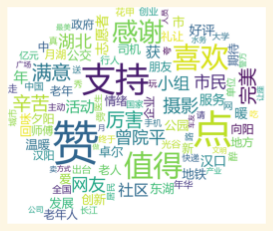

In [29]:
# 正面情感词词云
freq_pos = posdata.groupby(by = ['word'])['word'].count()
freq_pos = freq_pos.sort_values(ascending = False)
backgroud_Image=plt.imread(r'pl.jpg')
wordcloud = WordCloud(font_path="msyh.ttc",
                      max_words=100,
                      background_color='white',
                      mask=backgroud_Image)
pos_wordcloud = wordcloud.fit_words(freq_pos)
plt.imshow(pos_wordcloud)
plt.axis('off')
plt.savefig(r'positive.jpg')
plt.show()

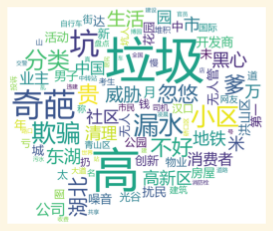

In [30]:
# 负面情感词词云
freq_neg = negdata.groupby(by = ['word'])['word'].count()
freq_neg = freq_neg.sort_values(ascending = False)
neg_wordcloud = wordcloud.fit_words(freq_neg)
plt.imshow(neg_wordcloud)
plt.axis('off')
plt.savefig(r'negative.jpg')
plt.show()

In [31]:
# 将结果写出,每条评论作为一行
posdata.to_csv(r'posdata.csv', index = False, encoding = 'utf-8')
negdata.to_csv(r'negdata.csv', index = False, encoding = 'utf-8')

In [32]:
# 载入情感分析后的数据
posdata = pd.read_csv(r'posdata.csv', encoding = 'utf-8')
negdata = pd.read_csv(r'negdata.csv', encoding = 'utf-8')

# 建立词典
pos_dict = corpora.Dictionary([[i] for i in posdata['word']])  # 正面
neg_dict = corpora.Dictionary([[i] for i in negdata['word']])  # 负面

# 建立语料库
pos_corpus = [pos_dict.doc2bow(j) for j in [[i] for i in posdata['word']]]  # 正面
neg_corpus = [neg_dict.doc2bow(j) for j in [[i] for i in negdata['word']]]   # 负面

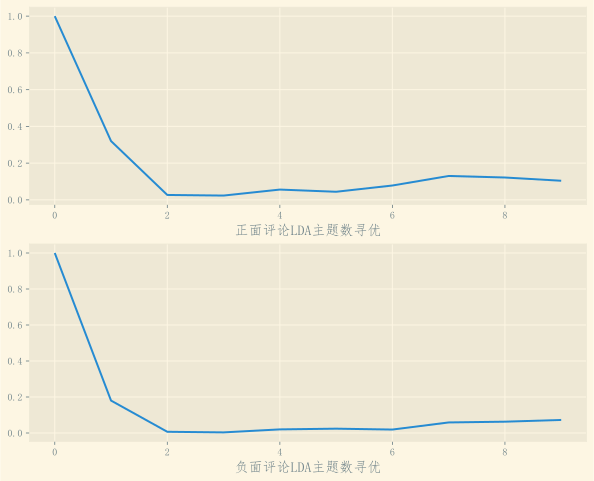

In [33]:
# 解决matplotlib中文变成小方格的问题
from pylab import mpl
mpl.rcParams['font.sans-serif'] = ['FangSong'] # 指定默认字体
mpl.rcParams['axes.unicode_minus'] = False # 解决保存图像是负号'-'显示为方块的问题

# 构造主题数寻优函数
def cos(vector1, vector2):  # 余弦相似度函数
    dot_product = 0.0;
    normA = 0.0;
    normB = 0.0;
    for a, b in zip(vector1, vector2):
        dot_product += a * b
        normA += a ** 2
        normB += b ** 2
    if normA == 0.0 or normB == 0.0:
        return (None)
    else:
        return (dot_product / ((normA * normB) ** 0.5))

    # 主题数寻优


def lda_k(x_corpus, x_dict):
    # 初始化平均余弦相似度
    mean_similarity = []
    mean_similarity.append(1)

    # 循环生成主题并计算主题间相似度
    for i in np.arange(2, 11):
        lda = models.LdaModel(x_corpus, num_topics=i, id2word=x_dict)  # LDA模型训练
        for j in np.arange(i):
            term = lda.show_topics(num_words=50)

        # 提取各主题词
        top_word = []
        for k in np.arange(i):
            top_word.append([''.join(re.findall('"(.*)"', i)) \
                             for i in term[k][1].split('+')])  # 列出所有词

        # 构造词频向量
        word = sum(top_word, [])  # 列出所有的词
        unique_word = set(word)  # 去除重复的词

        # 构造主题词列表，行表示主题号，列表示各主题词
        mat = []
        for j in np.arange(i):
            top_w = top_word[j]
            mat.append(tuple([top_w.count(k) for k in unique_word]))

        p = list(itertools.permutations(list(np.arange(i)), 2))
        l = len(p)
        top_similarity = [0]
        for w in np.arange(l):
            vector1 = mat[p[w][0]]
            vector2 = mat[p[w][1]]
            top_similarity.append(cos(vector1, vector2))

        # 计算平均余弦相似度
        mean_similarity.append(sum(top_similarity) / l)
    return (mean_similarity)

# 计算主题平均余弦相似度
pos_k = lda_k(pos_corpus, pos_dict)
neg_k = lda_k(neg_corpus, neg_dict)

# 绘制主题平均余弦相似度图形
font = FontProperties(size=14)

fig = plt.figure(figsize=(10,8))
ax1 = fig.add_subplot(211)
ax1.plot(pos_k)
ax1.set_xlabel('正面评论LDA主题数寻优', fontproperties=font)

ax2 = fig.add_subplot(212)
ax2.plot(neg_k)
ax2.set_xlabel('负面评论LDA主题数寻优', fontproperties=font)

plt.show()

In [34]:
# LDA主题分析
pos_lda = models.LdaModel(pos_corpus, num_topics = 10, id2word = pos_dict)
neg_lda = models.LdaModel(neg_corpus, num_topics = 10, id2word = neg_dict)
pos_topic = pos_lda.print_topics(num_words = 10)
neg_topic = neg_lda.print_topics(num_words = 10)

In [35]:
pos_theme = []
for p in pos_topic:
    word = re.findall('\*"(.*?)"',p[1])
    pos_theme.append(word)
pos_theme

[['赞', '支持', '厉害', '回味', '地方', '朋友', '警方', '高考', '引热议', '店'],
 ['点', '公交', '收官', '产业', '春晚', '小组', '热心', '热', '路', '萌'],
 ['完美', '老人', '中国', '深思', '时', '玩', '国家', '值得', '大学', '游'],
 ['喜欢', '感谢', '值得', '创新', '支持', '中', '满意', '秀', '摄影展', '现身'],
 ['满意', '地铁', '做', '请', '政府', '期待', '卖', '拥有', '小孩', '太'],
 ['辛苦', '市民', '歌', '荆楚网', '吃', '参与', '青年', '协和医院', '强国', '村民'],
 ['网友', '湖北', '赞', '网', '师傅', '月湖', '终于', '交警', '社会', '机'],
 ['卓尔', '爱', '汉口', '东湖', '发展', '拟', '快递', '新', '司机', '网友'],
 ['赞', '社区', '好评', '获', '亿元', '人民网', '爱情', '组图', '团队', '舞'],
 ['活动', '年', '摄影', '两', '服务', '出台', '创业', '北', '手机', '影城']]

In [36]:
neg_theme = []
for p in neg_topic:
    word = re.findall('\*"(.*?)"',p[1])
    neg_theme.append(word)
neg_theme

[['中国', '米', '真', '欺骗', '开发商', '全国', '迎', '挂', '国际', '一路'],
 ['坑', '爹', '医院', '业主', '月', '年', '交警', '卖', '环境', '地下'],
 ['高', '黑心', '名', '城市', '威胁', '新', '漏水', '岁', '消费者', '企业'],
 ['奇葩', '公司', '自行车', '心情', '上海', '发现', '江夏', '拆', '考生', '师生'],
 ['湖北', '园', '钱', '今日', '市', '垃圾', '城', '市长', '成', '老板'],
 ['忽悠', '贵', '不好', '慢', '东湖', '生活', '广告', '日', '遭', '价格'],
 ['太', '万', '恒大', '达', '万元', '停车', '大道', '工地', '街', '装修'],
 ['高', '小区', '中', '光谷', '店', '未', '奇葩', '曝光', '热', '房子'],
 ['地铁', '道', '狗', '促销', '无人管', '河', '讨薪', '亏', '扔', '差'],
 ['垃圾', '极差', '高新区', '第一', '湾', '成堆', '结束', '隧道', '成功', '弹']]